<a href="https://colab.research.google.com/github/ATOMScience-org/AMPL/blob/master/atomsci/ddm/examples/tutorials/10_Delaney_Solubility_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Predicting Solubility Using AMPL</h1>

The ATOM Modeling PipeLine (AMPL; https://github.com/ATOMScience-org/AMPL) is an open-source, modular, extensible software pipeline for building and sharing models to advance in silico drug discovery.


## Notebook execution time: ~ 3 minutes

In [1]:
!date

Sun 20 Mar 2022 12:01:05 PM PDT


# Goal: Predict solubility using the ATOM Modeling Pipeline (AMPL) on the public dataset

In this notebook, we describe the following steps using AMPL:

1.   Read a public dataset containing chemical structures and some properties
1.   Curate the dataset 
2.   Fit a simple model
3.   Predict solubility for withheld compounds


## Set up
We first import the AMPL modules for use in this notebook.

The relevant AMPL modules for this example are listed below:

|module|Description|
|-|-|
|`atomsci.ddm.pipeline.model_pipeline`|The model pipeline module is used to fit models and load models for prediction.|
|`atomsci.ddm.pipeline.parameter_parser`|The parameter parser reads through pipeline options for the model pipeline.|
|`atomsci.ddm.utils.curate_data`|The curate data module is used for data loading and pre-processing.|
|`atomsci.ddm.utils.struct_utils`|The structure utilities module is used to process loaded structures.|
|`atomsci.ddm.pipeline.perf_plots`|Perf plots contains a variety of plotting functions.|

## Install AMPL

In [2]:
! pip install rdkit-pypi
! pip install --pre deepchem

import deepchem
# print(deepchem.__version__)
! pip install umap
! pip install llvmlite==0.35.0  --ignore-installed
#! pip install llvmlite==0.38.0

! pip install umap-learn
! pip install molvs
! pip install bravado

/home/shoumo/anaconda3/envs/atomsci/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  Using cached llvmlite-0.35.0-cp37-cp37m-manylinux2010_x86_64.whl (25.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.55.1 requires llvmlite<0.39,>=0.38.0rc1, but you have llvmlite 0.35.0 which is incompatible.


In [3]:
import deepchem as dc

# get the Install AMPL_GPU_test.sh
! wget 'https://raw.githubusercontent.com/ATOMScience-org/AMPL/master/atomsci/ddm/examples/tutorials/config/install_AMPL_GPU_test.sh' >& /dev/null

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

mkdir: cannot create directory ‘github’: File exists
fatal: destination path 'AMPL' already exists and is not an empty directory.
M	atomsci/ddm/pipeline/model_wrapper.py
Already on 'master'
Your branch is up to date with 'origin/master'.
running build
running build_py
running egg_info
writing /home/shoumo/atom/AMPL-master/atomsci/ddm/examples/tutorials/github/AMPL.build/ampl/atomsci_ampl.egg-info/PKG-INFO
writing dependency_links to /home/shoumo/atom/AMPL-master/atomsci/ddm/examples/tutorials/github/AMPL.build/ampl/atomsci_ampl.egg-info/dependency_links.txt
writing namespace_packages to /home/shoumo/atom/AMPL-master/atomsci/ddm/examples/tutorials/github/AMPL.build/ampl/atomsci_ampl.egg-info/namespace_packages.txt
writing top-level names to /home/shoumo/atom/AMPL-master/atomsci/ddm/examples/tutorials/github/AMPL.build/ampl/atomsci_ampl.egg-info/top_level.txt
reading manifest file '/home/shoumo/atom/AMPL-master/atomsci/ddm/examples/tutorials/github/AMPL.build/ampl/atomsci_ampl.egg-info/S

adding license file "LICENSE" (matched pattern "LICEN[CS]E*")
adding license file "NOTICE" (matched pattern "NOTICE*")
creating /home/shoumo/atom/AMPL-master/atomsci/ddm/examples/tutorials/github/AMPL.build/ampl/bdist.linux-x86_64/wheel/atomsci_ampl-1.3.0.dist-info/WHEEL
creating '/home/shoumo/atom/AMPL-master/atomsci/ddm/examples/tutorials/github/AMPL.dist/atomsci_ampl-1.3.0-py3-none-any.whl' and adding '/home/shoumo/atom/AMPL-master/atomsci/ddm/examples/tutorials/github/AMPL.build/ampl/bdist.linux-x86_64/wheel' to it
adding 'atomsci_ampl-1.3.0-py3.7-nspkg.pth'
adding 'atomsci/ddm/__init__.py'
adding 'atomsci/ddm/data/descriptor_sets_sources_by_descr_type.csv'
adding 'atomsci/ddm/pipeline/GeneticAlgorithm.py'
adding 'atomsci/ddm/pipeline/MultitaskScaffoldSplit.py'
adding 'atomsci/ddm/pipeline/__init__.py'
adding 'atomsci/ddm/pipeline/ave_splitter.py'
adding 'atomsci/ddm/pipeline/chem_diversity.py'
adding 'atomsci/ddm/pipeline/compare_models.py'
adding 'atomsci/ddm/pipeline/dist_metric

In [4]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np
import pandas as pd
import os
import requests
import sys

import atomsci.ddm.pipeline.model_pipeline as mp
import atomsci.ddm.pipeline.parameter_parser as parse
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.utils.struct_utils as struct_utils
from atomsci.ddm.pipeline import perf_plots as pp


Using backend: pytorch
2022-03-20 12:01:19,992 Model tracker client not supported in your environment; will save models in filesystem only.


## Data curation

We then download and do very simple curation to the related dataset.

We need to set the directory we want to save files to. Next we download the dataset.

In [5]:
working_dir = '/content'

In [6]:
import io
url = 'https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv'
download = requests.get(url).content

In [7]:
# Reading the downloaded content and turning it into a pandas dataframe
raw_df = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=',', header=0 )

Next, we load the downloaded dataset, and process the compound structures:

In [8]:
data_orig = raw_df

In [9]:
raw_df.columns

Index(['Compound ID', 'ESOL predicted log solubility in mols per litre',
       'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
       'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area',
       'measured log solubility in mols per litre', 'smiles'],
      dtype='object')

In [10]:
raw_df.head(5)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [11]:
# base_smiles_from_smiles:
# Generate a standardized SMILES, InChI keys for dataset with curation and structure modules.
# RDkit modules are used to process the SMILES strings

# Default Arg options: 
# useIsomericSmiles = True
# removeCharges = False 

raw_df['rdkit_smiles'] = raw_df['smiles'].apply(curate_data.base_smiles_from_smiles)

## What happened after calling `base_smiles_from_smiles`?
Also remember the column name of the `rdkit_smiles`, we will use the standardized smiles later as input in our model calculations 

In [12]:
raw_df.head(4)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,rdkit_smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,Cc1occc1C(=O)Nc1ccccc1
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),CC(C)=CCCC(C)=CC=O
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21


## In the following cell, we will call smiles_to_inchi_key to create InChi Keys  

We will create InChi key (https://en.wikipedia.org/wiki/International_Chemical_Identifier) from SMILES string using RDKit. Note if for some reason, the convertion fails, you will see None as output

In [13]:
raw_df['inchi_key'] = raw_df['smiles'].apply(struct_utils.smiles_to_inchi_key)

## Note the addition of new column, inchi_key

In [14]:
raw_df.head(3)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,rdkit_smiles,inchi_key
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...,XUCIJNAGGSZNQT-UHFFFAOYSA-N
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,Cc1occc1C(=O)Nc1ccccc1,JFSPBVWPKOEZCB-UHFFFAOYSA-N
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),CC(C)=CCCC(C)=CC=O,WTEVQBCEXWBHNA-UHFFFAOYSA-N


In [15]:
data = raw_df
data['compound_id'] = data['inchi_key']

## Let us review the dataset

In [16]:
data.head(3)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,rdkit_smiles,inchi_key,compound_id
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...,XUCIJNAGGSZNQT-UHFFFAOYSA-N,XUCIJNAGGSZNQT-UHFFFAOYSA-N
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,Cc1occc1C(=O)Nc1ccccc1,JFSPBVWPKOEZCB-UHFFFAOYSA-N,JFSPBVWPKOEZCB-UHFFFAOYSA-N
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),CC(C)=CCCC(C)=CC=O,WTEVQBCEXWBHNA-UHFFFAOYSA-N,WTEVQBCEXWBHNA-UHFFFAOYSA-N


## Let us view some molecules

In [17]:
data['smiles'][0:10]

0    OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1                               Cc1occc1C(=O)Nc2ccccc2
2                                 CC(C)=CCCC(C)=CC(=O)
3                   c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4                                              c1ccsc1
5                                       c2ccc1scnc1c2 
6                   Clc1cc(Cl)c(c(Cl)c1)c2c(Cl)cccc2Cl
7                     CC12CCC3C(CCc4cc(O)ccc34)C2CCC1O
8       ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl
9     COc5cc4OCC3Oc2c1CC(Oc1ccc2C(=O)C3c4cc5OC)C(C)=C 
Name: smiles, dtype: object

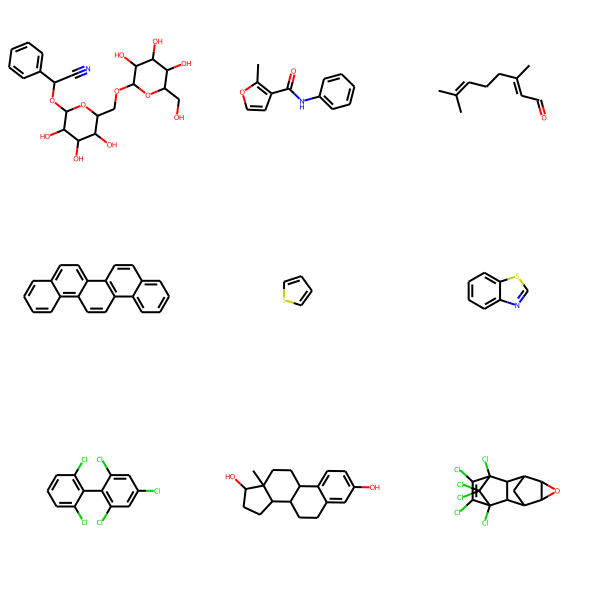

In [18]:
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice

molecules = [Chem.MolFromSmiles(smiles) for smiles in islice(data['smiles'], 9)]

Draw.MolsToGridImage(molecules)

The next step is to address the case where we have multiple measurements for a single structure (by RDkit canonical SMILEs string). We have a function in the `curate_data()` module to address the processing of compounds. The function parameters are listed below along with an explanation of each parameter:

In [19]:
data

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,rdkit_smiles,inchi_key,compound_id
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...,XUCIJNAGGSZNQT-UHFFFAOYSA-N,XUCIJNAGGSZNQT-UHFFFAOYSA-N
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2,Cc1occc1C(=O)Nc1ccccc1,JFSPBVWPKOEZCB-UHFFFAOYSA-N,JFSPBVWPKOEZCB-UHFFFAOYSA-N
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O),CC(C)=CCCC(C)=CC=O,WTEVQBCEXWBHNA-UHFFFAOYSA-N,WTEVQBCEXWBHNA-UHFFFAOYSA-N
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21,GBROPGWFBFCKAG-UHFFFAOYSA-N,GBROPGWFBFCKAG-UHFFFAOYSA-N
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1,c1ccsc1,YTPLMLYBLZKORZ-UHFFFAOYSA-N,YTPLMLYBLZKORZ-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br,FC(F)(F)C(Cl)Br,BCQZXOMGPXTTIC-UHFFFAOYSA-N,BCQZXOMGPXTTIC-UHFFFAOYSA-N
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C,CNC(=O)ON=C(SC)C(=O)N(C)C,KZAUOCCYDRDERY-UHFFFAOYSA-N,KZAUOCCYDRDERY-UHFFFAOYSA-N
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC,CCSCCSP(=S)(OC)OC,OPASCBHCTNRLRM-UHFFFAOYSA-N,OPASCBHCTNRLRM-UHFFFAOYSA-N
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C,CCC(C)C,QWTDNUCVQCZILF-UHFFFAOYSA-N,QWTDNUCVQCZILF-UHFFFAOYSA-N


In [20]:
# del_features = ['VALUE_NUM_mean', 'VALUE_NUM_std', 'Perc_Var', 'Remove_BadDuplicate']
# data.drop(labels=del_features, axis=1, inplace=True)

In [21]:
# column: Response values column
column = 'measured log solubility in mols per litre'

# tolerance: Percentage of individual respsonse values allowed to be different 
# from the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response value
# NOTE: In this example, we set this value very high to disable this feature
max_std = 100000

# compound_id: Compound ID column
compound_id = 'compound_id'

# smiles_col: SMILES column
smiles_col = 'rdkit_smiles'

# call the method `average_and_remove_duplicates` which changes the data and returns
# the new object as curated_df, in this case
 

curated_df = curate_data.average_and_remove_duplicates(column, 
                                                       tolerance, 
                                                       list_bad_duplicates, 
                                                       data, 
                                                       max_std, 
                                                       compound_id=compound_id, 
                                                       smiles_col=smiles_col)

Bad duplicates removed from dataset
Dataframe size (1128, 17)
List of 'bad' duplicates removed
Empty DataFrame
Columns: [compound_id, measured log solubility in mols per litre, VALUE_NUM_mean, Perc_Var, VALUE_NUM_std]
Index: []

Dataset de-duplicated
Dataframe size (1117, 17)
New column created with averaged values:  VALUE_NUM_mean


In [22]:
data.head(3)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,rdkit_smiles,inchi_key,compound_id
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...,XUCIJNAGGSZNQT-UHFFFAOYSA-N,XUCIJNAGGSZNQT-UHFFFAOYSA-N
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,Cc1occc1C(=O)Nc1ccccc1,JFSPBVWPKOEZCB-UHFFFAOYSA-N,JFSPBVWPKOEZCB-UHFFFAOYSA-N
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),CC(C)=CCCC(C)=CC=O,WTEVQBCEXWBHNA-UHFFFAOYSA-N,WTEVQBCEXWBHNA-UHFFFAOYSA-N


In [23]:
curated_df.head(3)

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,rdkit_smiles,inchi_key,compound_id,VALUE_NUM_mean,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,N#CC(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)c...,XUCIJNAGGSZNQT-UHFFFAOYSA-N,XUCIJNAGGSZNQT-UHFFFAOYSA-N,-0.77,NaN,-0.0,0
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,Cc1occc1C(=O)Nc1ccccc1,JFSPBVWPKOEZCB-UHFFFAOYSA-N,JFSPBVWPKOEZCB-UHFFFAOYSA-N,-3.30,NaN,-0.0,0
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),CC(C)=CCCC(C)=CC=O,WTEVQBCEXWBHNA-UHFFFAOYSA-N,WTEVQBCEXWBHNA-UHFFFAOYSA-N,-2.06,NaN,-0.0,0


In [24]:
print(os.path.join(working_dir))

/content


In [25]:
curated_file = os.path.join(working_dir, 'delaney_curated.csv')
curated_df.to_csv(curated_file, index=False)

Now that we have a curated dataset, we decide what type of featurizer and model we would like. See documentation for all available options. We also set the name of the new averaged response value column.

In [45]:
featurizer = 'ecfp'
model_type = 'NN'
response_cols = ['VALUE_NUM_mean']
feat1 = 5000
feat2 = 30
feat3 = 200
nn_max_epochs = 300
nn_learning_rate = 0.01
#nn_layer_sizes = 64
nn_dropouts = 0.18


Next we set up the parameters for our model. We set datastore and save_results to False to indicate that we are reading the input file and saving the results directly to the file system. There are a wide range of settable parameters; see the documentation for more details.

In [46]:
smiles_col

'rdkit_smiles'

In [47]:
params={"datastore": "False",
        "save_results": "False",
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_cols,
        "featurizer": featurizer,
        "model_type": model_type,
#        "rf_estimators": feat1,
#        "rf_max_depth": feat2,
#        "rf_max_features": feat3,
        "max_epochs": nn_max_epochs,
        "learning_rate": nn_learning_rate,
#        "layer_sizes": nn_layer_sizes,
        "dropouts": nn_dropouts,
        "result_dir": working_dir,
        "dataset_key": curated_file}

We use parse.wrapper to process our input configuration. We then build the model pipeline, train the model, and plot the predicted versus true values for our train, valid, test sets.

In [48]:
pparams = parse.wrapper(params)

2022-03-20 12:12:58,849 Created a dataset hash '9853835376556d330765da5c14bf5fce' from dataset_key '/content/delaney_curated.csv'


## Details of the following code chunk
 Here we create instances of the class ModelPipeline, called `MP`. The instance `MP` has access to data attributes and methods of the class. 

In [49]:
MP = mp.ModelPipeline(pparams)

## Use `dir` function to explore data attributes and functions associated with the class. 

The output is a list of data object attributes. Note the attributes that are surrounded by double-underscore (ex., `__le__`) are for internal use
and you dont have to worry about them. The regular (non underscore attributes) are of your concern. In the example shown below, these attributes start
with `'create_model_metadata'`

In [50]:
# dir(MP)

### Train_model:
Build model described by self.params on the training dataset described by self.params.Generate predictions for the training, validation, and test datasets, and save the predictions and performance metrics in the model results DB or in a JSON file.

## Note `train_model` is a method of class `ModelPipeline`. If you are using COLAB, mouse-over the `MP.train_model()` to view the source code

In [51]:
import atomsci.ddm.pipeline.model_pipeline as mp
mp.ampl_version

'1.3.0'

In [52]:
MP.train_model()

2022-03-20 12:13:00,331 This method is deprecated and will not be supported in the future
2022-03-20 12:13:00,333 ###### AMPL BUILD 3 layer #########3
2022-03-20 12:13:00,334 ###### setting layer sizes to 600, 350, 250, 120 #########3
2022-03-20 12:13:00,335 ###### past setting layer sizes #########
2022-03-20 12:13:00,387 Attempting to load featurized dataset
2022-03-20 12:13:00,394 Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
2022-03-20 12:13:00,395 Featurized dataset not previously saved for dataset delaney_curated, creating new
2022-03-20 12:13:00,404 Featurizing sample 0
2022-03-20 12:13:01,537 Featurizing sample 1000
2022-03-20 12:13:01,686 Splitting data by scaffold


number of features: 1024


2022-03-20 12:13:01,930 Dataset split table saved to /content/delaney_curated_train_valid_test_scaffold_cc9d7c27-88ab-485a-ab67-39eafbf9d8d0.csv
2022-03-20 12:13:01,938 Wrote transformers to /content/delaney_curated/NN_ecfp_scaffold_regression/a6034cd6-af1c-4857-bb40-87cf323f3981/transformers.pkl
2022-03-20 12:13:01,939 Transforming response data
2022-03-20 12:13:01,953 Transforming response data
2022-03-20 12:13:01,961 Transforming response data
2022-03-20 12:13:04,963 Total score for epoch 0 is -0.901
2022-03-20 12:13:04,979 Epoch 0: training r2_score = -0.115, validation r2_score = -0.901, test r2_score = -0.685
2022-03-20 12:13:05,110 *** Total score for epoch 1 is 0.117, is new maximum
2022-03-20 12:13:05,118 Epoch 1: training r2_score = 0.622, validation r2_score = 0.117, test r2_score = 0.133
2022-03-20 12:13:05,256 *** Total score for epoch 2 is 0.295, is new maximum
2022-03-20 12:13:05,267 Epoch 2: training r2_score = 0.778, validation r2_score = 0.295, test r2_score = 0.334
2

2022-03-20 12:13:13,153 Epoch 63: training r2_score = 0.950, validation r2_score = 0.370, test r2_score = 0.478
2022-03-20 12:13:13,289 Epoch 64: training r2_score = 0.939, validation r2_score = 0.245, test r2_score = 0.394
2022-03-20 12:13:13,430 Epoch 65: training r2_score = 0.949, validation r2_score = 0.349, test r2_score = 0.484
2022-03-20 12:13:13,568 Epoch 66: training r2_score = 0.922, validation r2_score = 0.352, test r2_score = 0.562
2022-03-20 12:13:13,721 Epoch 67: training r2_score = 0.923, validation r2_score = 0.337, test r2_score = 0.465
2022-03-20 12:13:13,842 Epoch 68: training r2_score = 0.942, validation r2_score = 0.364, test r2_score = 0.485
2022-03-20 12:13:13,964 Epoch 69: training r2_score = 0.929, validation r2_score = 0.325, test r2_score = 0.417
2022-03-20 12:13:14,089 Epoch 70: training r2_score = 0.950, validation r2_score = 0.364, test r2_score = 0.496
2022-03-20 12:13:14,223 Epoch 71: training r2_score = 0.941, validation r2_score = 0.220, test r2_score 

2022-03-20 12:13:22,877 Epoch 134: training r2_score = 0.943, validation r2_score = 0.329, test r2_score = 0.442
2022-03-20 12:13:23,000 Epoch 135: training r2_score = 0.939, validation r2_score = 0.367, test r2_score = 0.504
2022-03-20 12:13:23,140 Epoch 136: training r2_score = 0.951, validation r2_score = 0.346, test r2_score = 0.434
2022-03-20 12:13:23,278 Epoch 137: training r2_score = 0.947, validation r2_score = 0.323, test r2_score = 0.398
2022-03-20 12:13:23,416 Epoch 138: training r2_score = 0.935, validation r2_score = 0.350, test r2_score = 0.474
2022-03-20 12:13:23,566 Epoch 139: training r2_score = 0.946, validation r2_score = 0.354, test r2_score = 0.442
2022-03-20 12:13:23,698 Epoch 140: training r2_score = 0.940, validation r2_score = 0.315, test r2_score = 0.405
2022-03-20 12:13:23,845 Epoch 141: training r2_score = 0.952, validation r2_score = 0.332, test r2_score = 0.450
2022-03-20 12:13:23,993 Epoch 142: training r2_score = 0.948, validation r2_score = 0.346, test 

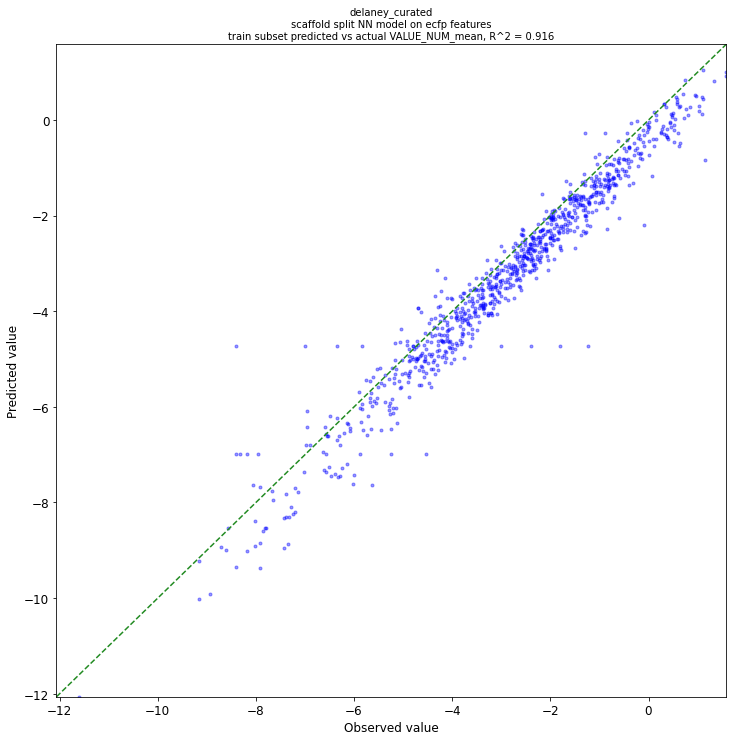

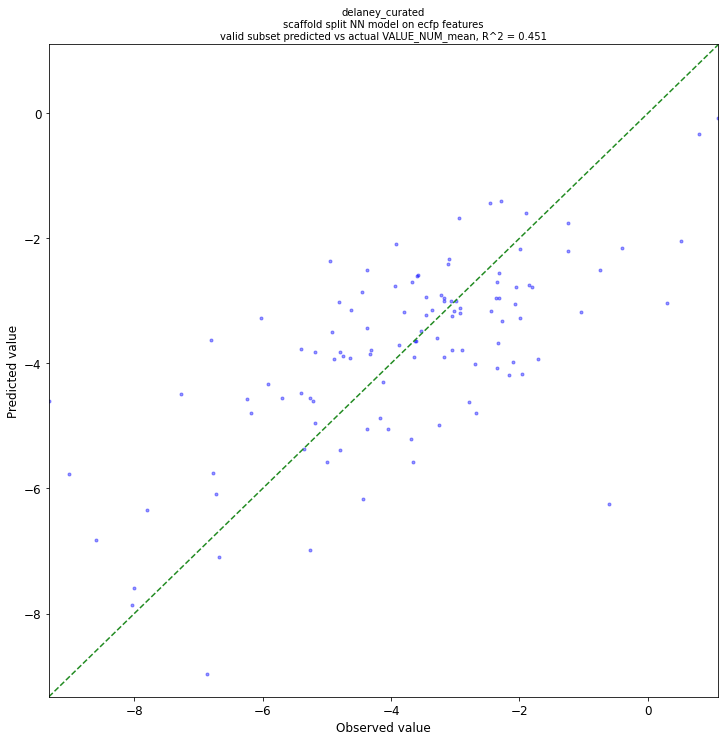

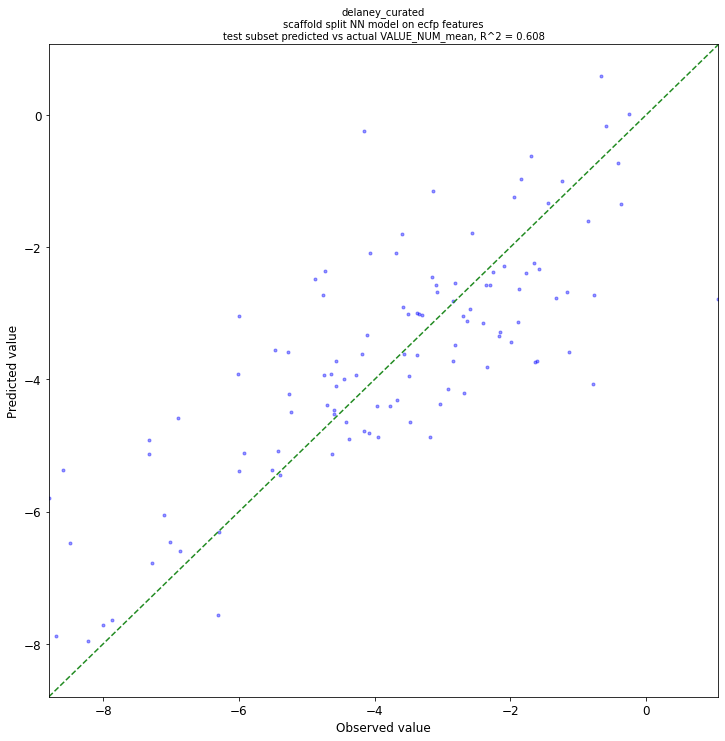

In [35]:


pp.plot_pred_vs_actual(MP)

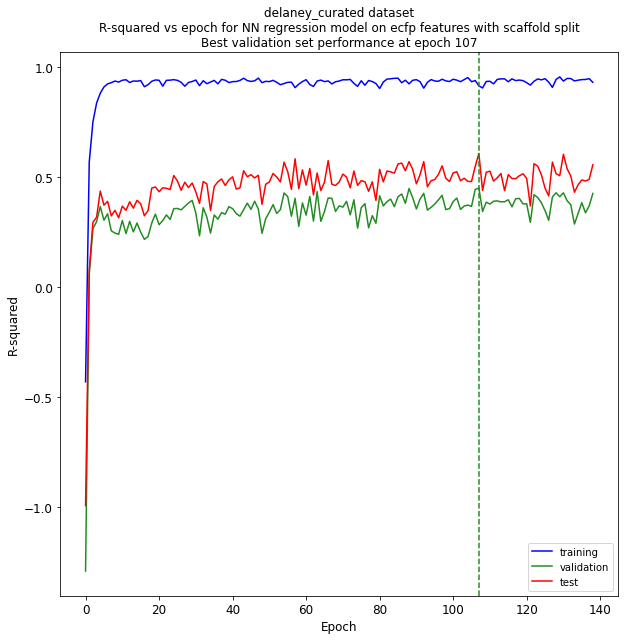

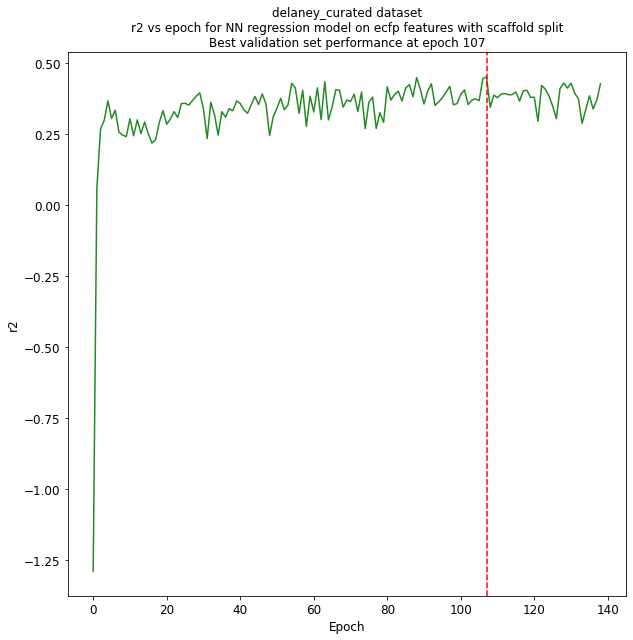

In [36]:
pp.plot_perf_vs_epoch(MP)

In [36]:
pp.plot_umap_feature_projections(MP)

AttributeError: module 'umap' has no attribute 'UMAP'

In [ ]:
pparams
# MP.train_model()

In [ ]:
!date

In [ ]:
featurizer = 'ecfp'
model_type = 'RF'
response_cols = ['VALUE_NUM_mean']
rf_estimators = 1000
rf_max_depth = 32
rf_max_features = 64
nn_max_epochs = 300
nn_learning_rate = 0.01
nn_layer_sizes = 64
nn_dropouts = 0.5


Next we set up the parameters for our model. We set datastore and save_results to False to indicate that we are reading the input file and saving the results directly to the file system. There are a wide range of settable parameters; see the documentation for more details.

In [ ]:
smiles_col

In [ ]:
params={"datastore": "False",
        "save_results": "False",
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_cols,
        "featurizer": featurizer,
        "model_type": model_type,
        "rf_estimators": rf_estimators,
        "rf_max_depth": rf_max_depth,
        "rf_max_features": rf_max_features,
#        "max_epochs": nn_max_epochs,
#        "learning_rate": nn_learning_rate,
#        "layer_sizes": nn_layer_sizes,
#        "dropouts": nn_dropouts,
        "result_dir": working_dir,
        "dataset_key": curated_file}

We use parse.wrapper to process our input configuration. We then build the model pipeline, train the model, and plot the predicted versus true values for our train, valid, test sets.

In [ ]:
pparams = parse.wrapper(params)

## Details of the following code chunk
 Here we create instances of the class ModelPipeline, called `MP`. The instance `MP` has access to data attributes and methods of the class. 

In [ ]:
MP = mp.ModelPipeline(pparams)

## Use `dir` function to explore data attributes and functions associated with the class. 

The output is a list of data object attributes. Note the attributes that are surrounded by double-underscore (ex., `__le__`) are for internal use
and you dont have to worry about them. The regular (non underscore attributes) are of your concern. In the example shown below, these attributes start
with `'create_model_metadata'`

In [ ]:
#dir(MP)

### Train_model:
Build model described by self.params on the training dataset described by self.params.Generate predictions for the training, validation, and test datasets, and save the predictions and performance metrics in the model results DB or in a JSON file.

## Note `train_model` is a method of class `ModelPipeline`. If you are using COLAB, mouse-over the `MP.train_model()` to view the source code

In [ ]:
import atomsci.ddm.pipeline.model_pipeline as mp
mp.ampl_version

In [ ]:
model=MP.train_model()

In [ ]:
pp.plot_pred_vs_actual(MP)

In [ ]:
pparams

In [ ]:
# pp.plot_umap_feature_projections(MP)

In [ ]:
model = MP.model_wrapper.reload_model("/content/delaney_curated/RF_ecfp_scaffold_regression/e06b38a2-1317-4310-9697-474a53d88f32/best_model")

In [ ]:
import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])


In [ ]:
!date

In [ ]:
featurizer = 'ecfp'
model_type = 'xgboost'
response_cols = ['VALUE_NUM_mean']
xgb_n_estimators = 500
xgb_max_depth = 12
xgb_learning_rate = 0.01
nn_max_epochs = 300
nn_learning_rate = 0.01
nn_layer_sizes = 64
nn_dropouts = 0.5


Next we set up the parameters for our model. We set datastore and save_results to False to indicate that we are reading the input file and saving the results directly to the file system. There are a wide range of settable parameters; see the documentation for more details.

In [ ]:
smiles_col

In [ ]:
params={"datastore": "False",
        "save_results": "False",
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_cols,
        "featurizer": featurizer,
        "model_type": model_type,
        "xgb_n_estimators": xgb_n_estimators,
        "xgb_max_depth": xgb_max_depth,
        "xgb_learning_rate": xgb_learning_rate,
#        "max_epochs": nn_max_epochs,
#        "learning_rate": nn_learning_rate,
#        "layer_sizes": nn_layer_sizes,
#        "dropouts": nn_dropouts,
        "result_dir": working_dir,
        "dataset_key": curated_file}

We use parse.wrapper to process our input configuration. We then build the model pipeline, train the model, and plot the predicted versus true values for our train, valid, test sets.

In [ ]:
pparams = parse.wrapper(params)

## Details of the following code chunk
 Here we create instances of the class ModelPipeline, called `MP`. The instance `MP` has access to data attributes and methods of the class. 

In [ ]:
MP = mp.ModelPipeline(pparams)

## Use `dir` function to explore data attributes and functions associated with the class. 

The output is a list of data object attributes. Note the attributes that are surrounded by double-underscore (ex., `__le__`) are for internal use
and you dont have to worry about them. The regular (non underscore attributes) are of your concern. In the example shown below, these attributes start
with `'create_model_metadata'`

In [ ]:
# dir(MP)

### Train_model:
Build model described by self.params on the training dataset described by self.params.Generate predictions for the training, validation, and test datasets, and save the predictions and performance metrics in the model results DB or in a JSON file.

## Note `train_model` is a method of class `ModelPipeline`. If you are using COLAB, mouse-over the `MP.train_model()` to view the source code

In [ ]:
import atomsci.ddm.pipeline.model_pipeline as mp
mp.ampl_version

In [ ]:
MP.train_model()

In [ ]:


pp.plot_pred_vs_actual(MP)

In [ ]:
pparams

In [ ]:
!date